In [ ]:
# Importing numpy
import numpy as np

# Importing pandas
import pandas as pd

# Importing PCA
from sklearn.decomposition import PCA

# Importing MDS
from sklearn.manifold import MDS

# Importing T-SNE
from sklearn.manifold import TSNE

# Importing train test split function
from sklearn.model_selection import train_test_split

# Importing Seaborn
import seaborn as sns

# Importing matplotlib
import matplotlib.pyplot as plt

# Importing K-Means Clustering
from sklearn.cluster import KMeans, DBSCAN

# Importing Logistic Regression Cross-Validation function
from sklearn.linear_model import LogisticRegressionCV

# Importing Warnings
import warnings

# Importing pickle
import pickle

# suppress FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

## Problem 1

In [ ]:
# Loading the data
X=np.load("X2.npy")

# Printing the shape of the resulting datasets
print(f"X shape: Number of cells (rows) {X.shape[0]} | Number of genes (columns) {X.shape[1]}")

# Calculating max X value for the first column
print(f"Max X for the first column: {np.max(X[:,0])}")

# Transforming the X data to log2
X_log = np.log2(X+1)

# Calculating max Xlog value for the first column
print(f"Max Xlog for the first column: {np.max(X_log[:,0])}")

In [ ]:
# Clustering cells
kmeans_X_log = KMeans(n_clusters=3, n_init=100).fit(X_log)

# Calculating PCA for the X_log matrix
pca_X_log = PCA(n_components=0.85)
pca_X_log.fit(X_log.T);

# Print summary of the PCA calculation result
print(f"Explained variance: {round(np.sum(pca_X_log.explained_variance_ratio_),3)}")
print(f"Number of components ('Genes' components): {pca_X_log.n_components_}")

# Creating a PCA embedding with the X_log data
pca_embedding_X_log = pca_X_log.components_.T

# Printing the shape of the resulting datasets
print(f"X_log PCA shape: Number of cells (rows) {pca_embedding_X_log.shape[0]} | Number of PC genes (columns) {pca_embedding_X_log.shape[1]}")

In [ ]:
# set the size of the plot
plt.figure(figsize=(8, 6))

# Plotting clusters in the T-SNE embedding
sns.scatterplot(x=pca_embedding_X_log[:,0], y=pca_embedding_X_log[:,1], hue=kmeans_X_log.labels_)

# add custom title, x-label, and y-label
plt.title("Brain cells types explained by the two first principal components (PC) for genes using PCA embedding")
plt.xlabel("PC1 for Genes")
plt.ylabel("PC2 for Genes")

# display the plot
plt.show()

In [ ]:
# Creating a MDS embedding
mds_embedding_X_log = MDS(n_components=2).fit_transform(X_log)

# set the size of the plot
plt.figure(figsize=(8, 6))

# Plotting clusters in the T-SNE embedding
sns.scatterplot(x=mds_embedding_X_log[:,0], y=mds_embedding_X_log[:,1], hue=kmeans_X_log.labels_)

# add custom title, x-label, and y-label
plt.title("Brain cells types explained by the two first principal components (PC) for genes using MDS embedding")
plt.xlabel("PC1 for Genes")
plt.ylabel("PC2 for Genes")

# display the plot
plt.show()

In [ ]:
# Creating a T-SNE embedding with the PCA embedding data
tsne_embedding_X_log = TSNE(n_components=2, perplexity=55).fit_transform(X_log)

# set the size of the plot
plt.figure(figsize=(8, 6))

# Plotting clusters in the T-SNE embedding
sns.scatterplot(x=tsne_embedding_X_log[:,0], y=tsne_embedding_X_log[:,1], hue=kmeans_X_log.labels_+1)

# add custom title, x-label, and y-label
plt.title(f"Brain cells sub-types explained by genes principal components (PC) using t-SNE embedding (Perplexity: {55})")
plt.xlabel("Genes PC1")
plt.ylabel("Genes PC2")

# display the plot
plt.show()

In [ ]:
# Creating cluster using DBSCAN
dbscan_clusters = DBSCAN(eps=1.51, min_samples=10).fit(tsne_embedding_X_log)

In [ ]:
cluster_df = (
    pd.DataFrame(tsne_embedding_X_log, columns=['PC1', 'PC2'], index=dbscan_clusters.labels_+1)
    .reset_index()
    .rename(columns={'index':'cell_sub_type'})
    .assign(cell_type = lambda x:np.where(x.cell_sub_type.isin([0,1,2,3]), 1, np.where(x.cell_sub_type.isin([8,9,10,11]), 2, 3)))
    [['cell_type', 'cell_sub_type', 'PC1', 'PC2']]
)

cluster_df

In [ ]:
(
    cluster_df
    .assign(PC1_min = lambda x:x.PC1)
    .assign(PC1_max = lambda x:x.PC1)
    .assign(PC1_mean = lambda x:x.PC1)
    .assign(PC2_min = lambda x:x.PC2)
    .assign(PC2_max = lambda x:x.PC2)
    .assign(PC2_mean = lambda x:x.PC2)
    .groupby(['cell_type'])
    .agg({
        'PC1_min':np.min,
        'PC1_max':np.max,
        'PC1_mean':np.mean,
        'PC2_min':np.min,
        'PC2_max':np.max,
        'PC2_mean':np.mean
    })
    .reset_index()
    .assign(PC1_Domain = lambda x: [f"[{round(i,2)}, {round(j,2)}]" for i, j in zip(x.PC1_min, x.PC1_max)])
    .assign(PC2_Domain = lambda x: [f"[{round(i,2)}, {round(j,2)}]" for i, j in zip(x.PC2_min, x.PC2_max)])
    .assign(Center = lambda x: [f"[{round(i,2)}, {round(j,2)}]" for i, j in zip(x.PC1_mean, x.PC2_mean)])
    [['cell_type', 'PC1_Domain', 'PC2_Domain', 'Center']]
)

In [ ]:
# create a figure with 3 subplots in a row
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

# create a scatter plot in each subplot
sns.scatterplot(data=cluster_df[cluster_df.cluster.isin([0,1,2,3])], x="PC1", y="PC2", hue="cluster", ax=axs[0], palette=sns.color_palette("hls", 4))
sns.scatterplot(data=cluster_df[cluster_df.cluster.isin([8,9,10,11])], x="PC1", y="PC2", hue="cluster", ax=axs[1], palette=sns.color_palette("hls", 4))
sns.scatterplot(data=cluster_df[cluster_df.cluster.isin([4,5,6,7])], x="PC1", y="PC2", hue="cluster", ax=axs[2], palette=sns.color_palette("hls", 4))

# add custom titles to each subplot
axs[0].set_title("Cell type I")
axs[1].set_title("Cell type II")
axs[2].set_title("Cell type III")

# add custom x-labels and y-labels to each subplot
axs[0].set_xlabel("Genes PC1")
axs[0].set_ylabel("Genes PC2")
axs[1].set_xlabel("Genes PC1")
axs[1].set_ylabel("Genes PC2")
axs[2].set_xlabel("Genes PC1")
axs[2].set_ylabel("Genes PC2")

# adjust the space between subplots
plt.subplots_adjust(wspace=0.3)

# display the plot
plt.show()


## Problem 2

In [ ]:
# set the size of the plot
plt.figure(figsize=(12, 8))

sns.scatterplot(data=cluster_df, x="PC1", y="PC2", hue="cluster", palette=sns.color_palette("hls", 12))

# add custom title, x-label, and y-label
plt.title(f"Brain cells sub-types explained by genes principal components (PC) using t-SNE embedding (Perplexity: {55}) - Clusters created using DBSCAN")
plt.xlabel("Genes PC1")
plt.ylabel("Genes PC2")

# display the plot
plt.show()

In [ ]:
(
    cluster_df
    .assign(cell_sub_type = lambda x: np.where(x.cell_sub_type == 0, 1, x.cell_sub_type))
    .assign(PC1_min = lambda x:x.PC1)
    .assign(PC1_max = lambda x:x.PC1)
    .assign(PC1_mean = lambda x:x.PC1)
    .assign(PC2_min = lambda x:x.PC2)
    .assign(PC2_max = lambda x:x.PC2)
    .assign(PC2_mean = lambda x:x.PC2)
    .groupby(['cell_type', 'cell_sub_type'])
    .agg({
        'PC1_min':np.min,
        'PC1_max':np.max,
        'PC1_mean':np.mean,
        'PC2_min':np.min,
        'PC2_max':np.max,
        'PC2_mean':np.mean
    })
    .reset_index()
    .assign(PC1_Domain = lambda x: [f"[{round(i,2)}, {round(j,2)}]" for i, j in zip(x.PC1_min, x.PC1_max)])
    .assign(PC2_Domain = lambda x: [f"[{round(i,2)}, {round(j,2)}]" for i, j in zip(x.PC2_min, x.PC2_max)])
    .assign(Center = lambda x: [f"[{round(i,2)}, {round(j,2)}]" for i, j in zip(x.PC1_mean, x.PC2_mean)])
    [['cell_type', 'cell_sub_type', 'PC1_Domain', 'PC2_Domain', 'Center']]
)

In [ ]:
labels_df = (
    cluster_df
    .assign(cell_sub_type = lambda x: np.where(x.cell_sub_type == 0, 1, x.cell_sub_type))
    [['cell_sub_type']]
)

In [ ]:
#labels_df.to_csv("p2_cluster_labels_X_FT")

## Logistic Regression

### Part 1

In [ ]:
# Defining X
X = np.load("X2.npy")

# Transforming the X data to log2
X_log = np.log2(X+1)

# Defining y
y = pd.read_csv("p2_cluster_labels_X_FT").cell_sub_type.values

# Splitting dataset into train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_log, y, test_size=0.30, stratify=y, random_state=42)

print(f"X_train size: {X_train.shape[0]} | y_train size: {y_train.shape[0]}")
print(f"X_test  size: {X_test.shape[0]}  | y_test  size: {y_test.shape[0]}")

In [ ]:
# Implementing cross-validation on logistic regression
cv_clf = LogisticRegressionCV(
    cv=5,                   # number of cross-validation folds
    Cs=100,                 # number of regularization values to attempt
    penalty='l1',           # penalty to implement: l1 - Lasso and l2 - Ridge
    solver='liblinear',     # solver that allows l1 and l2 regularizations
    tol=1e-5,               # tolerance
    max_iter=100,           # max number of iterations
    multi_class='ovr',      # in a multi-class context it will be performed one-versus-all
    random_state=42         # random state
).fit(X_train, y_train)

In [ ]:
#pickle.dump(cv_clf, open("cv_clf.pickle", "wb"))

In [ ]:
# Reading model
cv_clf = pickle.load(open("cv_clf.pickle", "rb"))

In [ ]:
# overall performance
print(f"Overall Accuracy: {round(np.mean(1*(cv_clf.predict(X_test) == y_test)), 3)}")

In [ ]:
(
    pd.DataFrame(zip(y_test, 1*(cv_clf.predict(X_test) == y_test)), columns=['Cluster Label', 'True Positive (Predicted)'])
    .assign(Total = lambda x:1)
    .groupby(['Cluster Label'])
    .sum()
    .reset_index()
    .assign(Accuracy = lambda x:x['True Positive (Predicted)']/x.Total)
)

In [ ]:
# Save indexes for the best 100 features
#with open('index_100.npy', 'wb') as f:
#    np.save(f, index_100)

### Part 2

In [ ]:
# Loading the X p2 evaluation data and applying the log2(X+1) transformation
X_train_p2_eval = np.log2(np.load("X_train.npy")+1)
X_test_p2_eval  = np.log2(np.load("X_test.npy") +1)

# Selecting the 100 best features
index_best_100 = (-np.sum(np.abs(cv_clf.coef_), axis=0)).argsort()[:100]
X_train_p2_eval_best_100 = X_train_p2_eval[:,index_best_100]
X_test_p2_eval_best_100   = X_test_p2_eval[:,index_best_100]

# Selecting 100 random features
np.random.seed(42)
index_random_100 = np.random.choice(a=range(0, X_train_p2_eval.shape[1]), size=100)
X_train_p2_eval_random_100 = X_train_p2_eval[:,index_random_100]
X_test_p2_eval_random_100  = X_test_p2_eval[:,index_random_100]

# Selecting the 100 features with the highest variance
index_high_variance_100 = (-np.std(X_train_p2_eval, axis=0)).argsort()[:100]
X_train_p2_eval_high_variance_100 = X_train_p2_eval[:,index_high_variance_100]
X_test_p2_eval_high_variance_100  = X_test_p2_eval[:,index_high_variance_100]

# Loading the y p2 evaluation data
y_train_p2_eval = np.load("y_train.npy")
y_test_p2_eval = np.load("y_test.npy")

In [ ]:
# Re-evaluate the model implementing cross-validation on logistic regression using the reduced dataset X_small
cv_clf_best_100 = LogisticRegressionCV(
    cv=5,                   # number of cross-validation folds
    Cs=100,                 # number of regularization values to attempt
    penalty='l1',           # penalty to implement: l1 - Lasso and l2 - Ridge
    solver='liblinear',     # solver that allows l1 and l2 regularizations
    tol=1e-5,               # tolerance
    max_iter=1000,          # max number of iterations
    multi_class='ovr',      # in a multi-class context it will be performed one-versus-all
    random_state=42         # random state
).fit(X_train_p2_eval_best_100, y_train_p2_eval)

In [ ]:
pickle.dump(cv_clf_best_100, open("cv_clf_best_100.pickle", "wb"))

In [ ]:
# Re-evaluate the model implementing cross-validation on logistic regression using the reduced dataset X_small
cv_clf_random_100 = LogisticRegressionCV(
    cv=5,                  # number of cross-validation folds
    Cs=100,                 # number of regularization values to attempt
    penalty='l1',           # penalty to implement: l1 - Lasso and l2 - Ridge
    solver='liblinear',     # solver that allows l1 and l2 regularizations
    tol=1e-3,               # tolerance
    max_iter=100,          # max number of iterations
    multi_class='ovr',      # in a multi-class context it will be performed one-versus-all
    random_state=42         # random state
).fit(X_train_p2_eval_random_100, y_train_p2_eval)

In [ ]:
pickle.dump(cv_clf_random_100, open("cv_clf_random_100.pickle", "wb"))

In [ ]:
# Re-evaluate the model implementing cross-validation on logistic regression using the reduced dataset X_small
cv_clf_high_variance_100 = LogisticRegressionCV(
    cv=5,                   # number of cross-validation folds
    Cs=100,                 # number of regularization values to attempt
    penalty='l1',           # penalty to implement: l1 - Lasso and l2 - Ridge
    solver='liblinear',     # solver that allows l1 and l2 regularizations
    tol=1e-5,               # tolerance
    max_iter=1000,          # max number of iterations
    multi_class='ovr',      # in a multi-class context it will be performed one-versus-all
    random_state=42         # random state
).fit(X_train_p2_eval_high_variance_100, y_train_p2_eval)

In [ ]:
pickle.dump(cv_clf_high_variance_100, open("cv_clf_high_variance_100.pickle", "wb"))

In [ ]:
# overall performance
print(f"Best 100 features overall Accuracy: {round(np.mean(1*(cv_clf_best_100.predict(X_test_p2_eval_best_100) == y_test_p2_eval)), 3)}")
print(f"Random 100 features overall Accuracy: {round(np.mean(1*(cv_clf_random_100.predict(X_test_p2_eval_random_100) == y_test_p2_eval)), 3)}")
print(f"High Variance 100 features overall Accuracy: {round(np.mean(1*(cv_clf_high_variance_100.predict(X_test_p2_eval_high_variance_100) == y_test_p2_eval)), 3)}")

In [ ]:
# Best 100 features overall Accuracy: 0.889
# Random 100 features overall Accuracy: 0.206
# High Variance 100 features overall Accuracy: 0.892

In [ ]:
var_df = (
    pd.concat([
        pd.DataFrame(zip(np.var(X_train_p2_eval_high_variance_100, axis=0), 100*['Highest Variance Features']), columns=['Variance', 'Features Set']),
        pd.DataFrame(zip(np.var(X_train_p2_eval_best_100, axis=0), 100*['Best Features']), columns=['Variance', 'Features Set'])
    ], axis=0)
    .reset_index()
)

var_df

In [ ]:
sns.color_palette("hls", 4)[0]

In [ ]:
# set the size of the plot
plt.figure(figsize=(12, 8))

sns.histplot(data=var_df, x="Variance", hue="Features Set", palette=sns.color_palette("hls", 2))

# add custom title, x-label, and y-label
plt.title(f"Variance Distribution | Highest Variance Features versus Best Features")
plt.xlabel("Variance")
plt.ylabel("Density")

# display the plot
plt.show()

In [ ]:
pd.concat([
    pd.DataFrame(np.var(X_train_p2_eval, axis=0), columns=['Variance (All Features)']).describe(),
    pd.DataFrame(np.var(X_train_p2_eval_random_100, axis=0), columns=['variance (Random Features)']).describe(),
    pd.DataFrame(np.var(X_train_p2_eval_best_100, axis=0), columns=['variance (Best Features)']).describe(),
    pd.DataFrame(np.var(X_train_p2_eval_high_variance_100, axis=0), columns=['variance (High Variance Features)']).describe(),
], axis=1
)

In [ ]:


# set the size of the plot
plt.figure(figsize=(12, 8))

sns.histplot(x=np.var(X_train_p2_eval, axis=0))

# add custom title, x-label, and y-label
plt.title(f"Variance Distribution | Highest Variance Features versus Best Features")
plt.xlabel("Variance")
plt.ylabel("Density")

# display the plot
plt.show()

In [ ]:
# Creating a dataframe to hold cluster's labels
cluster_label_df = pd.DataFrame(
    y_test_p2_eval, 
    columns=['Cluster Label']
)

# Creating a dataframe to hold the results of the prediction using the model with th 100 best features
prediction_best_100_df = pd.DataFrame(
    1*(cv_clf_best_100.predict(X_test_p2_eval_best_100) == y_test_p2_eval), 
    columns=['True Positive (Predicted - 100 Best)']
)

# Creating a dataframe to hold the results of the prediction using the model with th 100 random features
prediction_random_100_df = pd.DataFrame(
    1*(cv_clf_random_100.predict(X_test_p2_eval_best_100) == y_test_p2_eval), 
    columns=['True Positive (Predicted - 100 Random)']
)

# Creating a dataframe to hold the results of the prediction using the model with th 100 highest variance features
prediction_high_variance_100_df = pd.DataFrame(
    1*(cv_clf_high_variance_100.predict(X_test_p2_eval_best_100) == y_test_p2_eval), 
    columns=['True Positive (Predicted - 100 Highest Variance)']
)


(
    pd.concat([cluster_label_df, prediction_best_100_df, prediction_random_100_df, prediction_high_variance_100_df], axis=1)
    .assign(Total = lambda x:1)
    .groupby(['Cluster Label']).sum().reset_index()
    #.assign(Accuracy = lambda x:x['True Positive (Predicted)']/x.Total)
)



In [ ]:
(
    pd.DataFrame(zip(y_test, 1*(cv_clf_best_100.predict(X_test) == y_test_p2_eval)), columns=['Cluster Label', 'True Positive (Predicted)'])
    .assign(Total = lambda x:1)
    .groupby(['Cluster Label'])
    .sum()
    .reset_index()
    .assign(Accuracy = lambda x:x['True Positive (Predicted)']/x.Total)
)

In [ ]:
np.mean(1*(preds == y_test_p2_eval))

In [ ]:
(
    pd.DataFrame(zip(y_test_p2_eval, 1*(preds == y_test_p2_eval)), columns=['Cluster Label', 'True Positive (Predicted)'])
    .assign(Total = lambda x:1)
    .groupby(['Cluster Label'])
    .sum()
    .reset_index()
    .assign(Accuracy = lambda x:x['True Positive (Predicted)']/x.Total)
)

## Part 3

In [ ]:
# Loading the data
X=np.load("X2.npy")

# Printing the shape of the resulting datasets
print(f"X shape: Number of cells (rows) {X.shape[0]} | Number of genes (columns) {X.shape[1]}")

# Calculating max X value for the first column
print(f"Max X for the first column: {np.max(X[:,0])}")

# Transforming the X data to log2
X_log = np.log2(X+1)

# Calculating max Xlog value for the first column
print(f"Max Xlog for the first column: {np.max(X_log[:,0])}")

In [ ]:
# Clustering cells
kmeans_X_log = KMeans(n_clusters=3, n_init=100).fit(X_log)

# Calculating PCA for the X_log matrix
pca_X_log10 = PCA(n_components=10).fit(X_log.T)
pca_X_log50 = PCA(n_components=50).fit(X_log.T)
pca_X_log100 = PCA(n_components=100).fit(X_log.T)
pca_X_log250 = PCA(n_components=250).fit(X_log.T)
pca_X_log500 = PCA(n_components=500).fit(X_log.T)

# Creating a PCA embedding with the X_log data
pca_embedding_X_log10 = pca_X_log10.components_.T
pca_embedding_X_log50 = pca_X_log50.components_.T
pca_embedding_X_log100 = pca_X_log100.components_.T
pca_embedding_X_log250 = pca_X_log250.components_.T
pca_embedding_X_log500 = pca_X_log500.components_.T

In [ ]:
# Creating a T-SNE embedding with the PCA embedding data
tsne_embedding_X_log10 = TSNE(n_components=2, perplexity=40, learning_rate=100).fit_transform(pca_embedding_X_log10)
tsne_embedding_X_log50 = TSNE(n_components=2, perplexity=40).fit_transform(pca_embedding_X_log50)
tsne_embedding_X_log100 = TSNE(n_components=2, perplexity=40).fit_transform(pca_embedding_X_log100)
tsne_embedding_X_log250 = TSNE(n_components=2, perplexity=40).fit_transform(pca_embedding_X_log250)
tsne_embedding_X_log500 = TSNE(n_components=2, perplexity=40).fit_transform(pca_embedding_X_log500)

In [ ]:
# Creating a T-SNE embedding with the PCA embedding data
tsne_embedding_X_log10 = TSNE(n_components=2, perplexity=40, learning_rate=50).fit_transform(pca_embedding_X_log500)
tsne_embedding_X_log50 = TSNE(n_components=2, perplexity=40, learning_rate=100).fit_transform(pca_embedding_X_log500)
tsne_embedding_X_log100 = TSNE(n_components=2, perplexity=40, learning_rate=200).fit_transform(pca_embedding_X_log500)
tsne_embedding_X_log250 = TSNE(n_components=2, perplexity=40, learning_rate=500).fit_transform(pca_embedding_X_log500)
tsne_embedding_X_log500 = TSNE(n_components=2, perplexity=40, learning_rate=800).fit_transform(pca_embedding_X_log500)

In [ ]:
# create a figure with 3 subplots in a row
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

# create a scatter plot in each subplot
sns.scatterplot(x=tsne_embedding_X_log10[:,0], y=tsne_embedding_X_log10[:,1], hue=kmeans_X_log.labels_, ax=axs[0])
sns.scatterplot(x=tsne_embedding_X_log50[:,0], y=tsne_embedding_X_log50[:,1], hue=kmeans_X_log.labels_, ax=axs[1])
sns.scatterplot(x=tsne_embedding_X_log100[:,0], y=tsne_embedding_X_log100[:,1], hue=kmeans_X_log.labels_, ax=axs[2])
sns.scatterplot(x=tsne_embedding_X_log250[:,0], y=tsne_embedding_X_log250[:,1], hue=kmeans_X_log.labels_, ax=axs[3])
sns.scatterplot(x=tsne_embedding_X_log500[:,0], y=tsne_embedding_X_log500[:,1], hue=kmeans_X_log.labels_, ax=axs[4])

# add custom titles to each subplot
axs[0].set_title("10 PC's")
axs[1].set_title("50 PC's")
axs[2].set_title("100 PC's")
axs[3].set_title("250 PC's")
axs[4].set_title("500 PC's")

# add custom x-labels and y-labels to each subplot
axs[0].set_xlabel("Genes PC1")
axs[0].set_ylabel("Genes PC2")
axs[1].set_xlabel("Genes PC1")
axs[1].set_ylabel("Genes PC2")
axs[2].set_xlabel("Genes PC1")
axs[2].set_ylabel("Genes PC2")
axs[3].set_xlabel("Genes PC1")
axs[3].set_ylabel("Genes PC2")
axs[4].set_xlabel("Genes PC1")
axs[4].set_ylabel("Genes PC2")

#axs[0].set_xlim([-75,75])
#axs[0].set_ylim([-75,75])
#axs[1].set_xlim([-75,75])
#axs[1].set_ylim([-75,75])
#axs[2].set_xlim([-75,75])
#axs[2].set_ylim([-75,75])
#axs[3].set_xlim([-75,75])
#axs[3].set_ylim([-75,75])
#axs[4].set_xlim([-75,75])
#axs[4].set_ylim([-75,75])

# adjust the space between subplots
plt.subplots_adjust(wspace=0.3)

# display the plot
plt.show()


In [ ]:
# set the size of the plot
plt.figure(figsize=(12, 8))

sns.scatterplot(x=teste[:,0], y=teste[:,1], hue=kmeans_X_log.labels_)

# add custom title, x-label, and y-label
plt.title(f"Variance Distribution | Highest Variance Features versus Best Features")
plt.xlabel("Variance")
plt.ylabel("Density")

# display the plot
plt.show()

In [ ]:
# Creating an empty dictionary
tsne_dict = {}

# Defining list of parameter values
parameter_values = [1, 3, 5, 10, 25, 50, 100, 200]

# Defining shape of the final image
nrows = 2
ncols = 4

# create a figure with 3 subplots in a row
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 5*nrows))

# adjust the space between subplots
plt.subplots_adjust(wspace=0.3)

# Initializing indexes
r = 0
c = 0

for i, p in enumerate(parameter_values):

    # Creating a T-SNE embedding with the chosen perplexity value
    tsne_p = TSNE(n_components=2, perplexity=p, learning_rate=200, early_exaggeration=12).fit_transform(X_log)

    # Storing embedding
    tsne_dict[f"perplexity_{p}"] = tsne_p

    # Creating a dataframe using the t-SNE embedding
    tsne_df = pd.DataFrame(np.concatenate([tsne_p, kmeans_X_log.labels_.reshape(-1,1)], axis=1), columns=['PC1', 'PC2', 'Cluster'])

    # Calculating center   
    center = (
        tsne_df.groupby(['Cluster']).mean().reset_index()
        .drop(columns=['Cluster'])
        .mean()
    ).values

    # Create a scatter plot in each subplot
    sns.scatterplot(x=tsne_df.PC1 - center[0], y=tsne_df.PC2 - center[1], hue=tsne_df.Cluster, ax=axs[r,c])

    # Add custom titles to each subplot
    axs[r,c].set_title(f'Perplexity {p}')

    # Add custom x-labels and y-labels to each subplot
    axs[r,c].set_xlabel("Genes PC1")
    axs[r,c].set_ylabel("Genes PC2")

    axs[r,c].set_xlim([-70,70])
    axs[r,c].set_ylim([-70,70])
    
    # updating column index
    c += 1

    # Adjusting subplot indexes
    if(c == ncols):
        c = 0
        r += 1

# display the plot
plt.show()

In [ ]:
# Defining list of parameter values
parameter_values = [1, 3, 5, 10, 25, 50, 100, 200]

# Defining shape of the final image
nrows = 2
ncols = 4

# create a figure with 3 subplots in a row
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))

# adjust the space between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Initializing indexes
r = 0
c = 0

for i, p in enumerate(parameter_values):

    # Creating a dataframe using the t-SNE embedding
    tsne_df = pd.DataFrame(np.concatenate([tsne_dict[f"perplexity_{p}"], kmeans_X_log.labels_.reshape(-1,1)], axis=1), columns=['PC1', 'PC2', 'Cluster'])

    # Calculating center   
    center = (
        tsne_df.groupby(['Cluster']).mean().reset_index()
        .drop(columns=['Cluster'])
        .mean()
    ).values

    # Create a scatter plot in each subplot
    sns.scatterplot(x=tsne_df.PC1 - center[0], y=tsne_df.PC2 - center[1], hue=tsne_df.Cluster, ax=axs[r,c])

    # Add custom titles to each subplot
    axs[r,c].set_title(f'Perplexity {p}')

    # Add custom x-labels and y-labels to each subplot
    axs[r,c].set_xlabel("Genes PC1")
    axs[r,c].set_ylabel("Genes PC2")

    #axs[r,c].set_xlim([-70,70])
    #axs[r,c].set_ylim([-70,70])
    
    # updating column index
    c += 1

    # Adjusting subplot indexes
    if(c == ncols):
        c = 0
        r += 1

# display the plot
plt.show()

In [ ]:
# Creating an empty dictionary
tsne_dict = {}

# Defining list of parameter values
parameter_values = [0.01, 10, 100, 500, 1000, 2500, 5000, 10000]

# Defining shape of the final image
nrows = 2
ncols = 4

# create a figure with 3 subplots in a row
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 5*nrows))

# adjust the space between subplots
plt.subplots_adjust(wspace=0.3)

# Initializing indexes
r = 0
c = 0

for i, p in enumerate(parameter_values):

    # Creating a T-SNE embedding with the chosen perplexity value
    tsne_p = TSNE(n_components=2, perplexity=50, learning_rate=p, early_exaggeration=12).fit_transform(X_log)

    # Storing embedding
    tsne_dict[f"learning_rate_{p}"] = tsne_p

    # Creating a dataframe using the t-SNE embedding
    tsne_df = pd.DataFrame(np.concatenate([tsne_p, kmeans_X_log.labels_.reshape(-1,1)], axis=1), columns=['PC1', 'PC2', 'Cluster'])

    # Calculating center   
    center = (
        tsne_df.groupby(['Cluster']).mean().reset_index()
        .drop(columns=['Cluster'])
        .mean()
    ).values

    # Create a scatter plot in each subplot
    sns.scatterplot(x=tsne_df.PC1 - center[0], y=tsne_df.PC2 - center[1], hue=tsne_df.Cluster, ax=axs[r,c])

    # Add custom titles to each subplot
    axs[r,c].set_title(f'Learning Rate {p}')

    # Add custom x-labels and y-labels to each subplot
    axs[r,c].set_xlabel("Genes PC1")
    axs[r,c].set_ylabel("Genes PC2")

    axs[r,c].set_xlim([-40,40])
    axs[r,c].set_ylim([-40,40])
    
    # updating column index
    c += 1

    # Adjusting subplot indexes
    if(c == ncols):
        c = 0
        r += 1

# display the plot
plt.show()

In [ ]:
# Defining list of parameter values
parameter_values = [0.01, 10, 100, 500, 1000, 2500, 5000, 10000]

# Defining shape of the final image
nrows = 2
ncols = 4

# create a figure with 3 subplots in a row
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))

# adjust the space between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Initializing indexes
r = 0
c = 0

for i, p in enumerate(parameter_values):

    # Creating a dataframe using the t-SNE embedding
    tsne_df = pd.DataFrame(np.concatenate([tsne_dict[f"learning_rate_{p}"], kmeans_X_log.labels_.reshape(-1,1)], axis=1), columns=['PC1', 'PC2', 'Cluster'])

    # Calculating center   
    center = (
        tsne_df.groupby(['Cluster']).mean().reset_index()
        .drop(columns=['Cluster'])
        .mean()
    ).values

    # Create a scatter plot in each subplot
    sns.scatterplot(x=tsne_df.PC1 - center[0], y=tsne_df.PC2 - center[1], hue=tsne_df.Cluster, ax=axs[r,c])

    # Add custom titles to each subplot
    axs[r,c].set_title(f'Learning Rate {p}')

    # Add custom x-labels and y-labels to each subplot
    axs[r,c].set_xlabel("Genes PC1")
    axs[r,c].set_ylabel("Genes PC2")

    #axs[r,c].set_xlim([-70,70])
    #axs[r,c].set_ylim([-70,70])
    
    # updating column index
    c += 1

    # Adjusting subplot indexes
    if(c == ncols):
        c = 0
        r += 1

# display the plot
plt.show()

In [ ]:
# Defining list of parameter values
parameter_values = [0.01, 10, 100, 500, 1000, 2500, 5000, 10000]

# Defining shape of the final image
nrows = 2
ncols = 4

# create a figure with 3 subplots in a row
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))

# adjust the space between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Initializing indexes
r = 0
c = 0

for i, p in enumerate(parameter_values):

    # Creating a dataframe using the t-SNE embedding
    tsne_df = pd.DataFrame(np.concatenate([tsne_dict[f"learning_rate_{p}"], kmeans_X_log.labels_.reshape(-1,1)], axis=1), columns=['PC1', 'PC2', 'Cluster'])

    # Calculating center   
    center = (
        tsne_df.groupby(['Cluster']).mean().reset_index()
        .drop(columns=['Cluster'])
        .mean()
    ).values

    # Create a scatter plot in each subplot
    sns.scatterplot(x=tsne_df.PC1 - center[0], y=tsne_df.PC2 - center[1], hue=tsne_df.Cluster, ax=axs[r,c])

    # Add custom titles to each subplot
    axs[r,c].set_title(f'Learning Rate {p}')

    # Add custom x-labels and y-labels to each subplot
    axs[r,c].set_xlabel("Genes PC1")
    axs[r,c].set_ylabel("Genes PC2")

    axs[r,c].set_xlim([-50,60])
    axs[r,c].set_ylim([-50,60])
    
    # updating column index
    c += 1

    # Adjusting subplot indexes
    if(c == ncols):
        c = 0
        r += 1

# display the plot
plt.show()

In [ ]:
vec1 = np.random.normal(loc=[10, 30], scale=[4,4], size=(500,2))
vec2 = np.random.normal(loc=[20, -10], scale=[2,2], size=(500,2))
vec3 = np.random.normal(loc=[-5, 5], scale=[5,5], size=(500,2))

In [ ]:
X = np.concatenate([vec1, vec2, vec3], axis=0)

In [ ]:
indexes = np.random.choice(list(range(X.shape[0])), size=1500, replace=False)

In [ ]:
Xshuffle = X[indexes,:]

In [ ]:
noise = np.random.uniform(low=8, high=10, size=(1500, 200))

In [ ]:
Xshuffle_noise = np.concatenate([Xshuffle, noise], axis=1)

In [ ]:
# Creating a T-SNE embedding with the chosen perplexity value
tsne_X = TSNE(n_components=2, perplexity=50, learning_rate=500, early_exaggeration=12).fit_transform(Xshuffle)

In [ ]:
# set the size of the plot
plt.figure(figsize=(12, 8))

sns.scatterplot(x=tsne_X[:,0], y=tsne_X[:,1])

# add custom title, x-label, and y-label
plt.title(f"Variance Distribution | Highest Variance Features versus Best Features")
plt.xlabel("Variance")
plt.ylabel("Density")

# display the plot
plt.show()

In [ ]:
# Creating a T-SNE embedding with the chosen perplexity value
tsne_noise = TSNE(n_components=2, perplexity=50, learning_rate=500, early_exaggeration=12).fit_transform(Xshuffle_noise)

# set the size of the plot
plt.figure(figsize=(12, 8))

sns.scatterplot(x=tsne_noise[:,0], y=tsne_noise[:,1])

# add custom title, x-label, and y-label
plt.title(f"Variance Distribution | Highest Variance Features versus Best Features")
plt.xlabel("Variance")
plt.ylabel("Density")

# display the plot
plt.show()

In [ ]:
# Calculating PCA for the X_log matrix
pca_Xnoise = PCA(n_components=50).fit(Xshuffle_noise.T);

In [ ]:
# Creating a T-SNE embedding with the chosen perplexity value
tsne_noise_pca = TSNE(n_components=2, perplexity=50, learning_rate=500, early_exaggeration=12).fit_transform(pca_Xnoise.components_.T)

# set the size of the plot
plt.figure(figsize=(12, 8))

sns.scatterplot(x=tsne_noise_pca[:,0], y=tsne_noise_pca[:,1])

# add custom title, x-label, and y-label
plt.title(f"Variance Distribution | Highest Variance Features versus Best Features")
plt.xlabel("Variance")
plt.ylabel("Density")

# display the plot
plt.show()

In [2]:
# Importing numpy
import numpy as np

# Importing pandas
import pandas as pd

# Importing PCA
from sklearn.decomposition import PCA

# Importing MDS
from sklearn.manifold import MDS

# Importing T-SNE
from sklearn.manifold import TSNE

# Importing train test split function
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

# Importing Seaborn
import seaborn as sns

# Importing matplotlib
import matplotlib.pyplot as plt

# Importing K-Means Clustering
from sklearn.cluster import KMeans, DBSCAN

# Importing Logistic Regression Cross-Validation function
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

# Importing Warnings
import warnings

# Importing pickle
import pickle

import time

# suppress FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Loading the X p2 evaluation data and applying the log2(X+1) transformation
Xtr_eval = np.log2(np.load("X_train.npy")+1)
Xtt_eval = np.log2(np.load("X_test.npy")+1)

# Loading the y p2 evaluation data
ytr_eval = np.load("y_train.npy")
ytt_eval = np.load("y_test.npy")

In [4]:
scaler = StandardScaler()

scaler.fit(Xtr_eval)

XtrZ = scaler.transform(Xtr_eval)
XttZ = scaler.transform(Xtt_eval)

In [20]:
#cv_reg_dict = {}
regs = [1e7, 1e8]


for i, r in enumerate(regs):

    start_time = time.time()

    # Re-evaluate the model implementing cross-validation on logistic regression using the reduced dataset X_small
    cv_clf = LogisticRegression(
        C=r,
        penalty='l2',
        solver='liblinear', 
        tol=1e-4,
        max_iter=1000,
        multi_class='ovr',
    ).fit(XtrZ, ytr_eval)

    l2_models[13+i] = cv_clf

    pickle.dump(l2_models, open("l2_models_dict_04.pickle", "wb"))

    print(f"Run Time {i}: {time.time() - start_time} seconds")

Run Time 0: 921.3808135986328 seconds
Run Time 1: 993.2077567577362 seconds


In [19]:
cv_reg_dict = {}
regs = [1e7, 1e8]


for i, r in enumerate(regs):

    start_time = time.time()

    # Re-evaluate the model implementing cross-validation on logistic regression using the reduced dataset X_small
    cv_clf = LogisticRegression(
        C=r,
        penalty='l1',
        solver='liblinear', 
        tol=1e-4,   
        max_iter=1000,
        multi_class='ovr',
    ).fit(XtrZ, ytr_eval)

    cv_reg_dict[i] = cv_clf
    #l1_models[13+i] = cv_clf

    pickle.dump(cv_reg_dict, open("l1_models_dict_04.pickle", "wb"))

    print(f"Run Time {i}: {time.time() - start_time} seconds")

Run Time 0: 110.09168148040771 seconds
Run Time 1: 110.9074227809906 seconds


In [21]:
pickle.dump(l1_models, open("l1_models_dict_04.pickle", "wb"))

In [22]:
# Reading model
l1_models = pickle.load(open("l1_models_dict_04.pickle", "rb"))
l2_models = pickle.load(open("l2_models_dict_04.pickle", "rb"))

In [202]:
n_fts = 50

l1_features_dict = {}
l2_features_dict = {}

for i, m in enumerate(l1_models):

    # Calculating sum of coeficients and ordering it
    #sum_abs_coefs = np.sum(np.abs(l1_models[m].coef_), axis=0)
    sum_abs_coefs = np.abs(np.sum(l1_models[m].coef_, axis=0))
    ordered_sum_abs_coefs = np.argsort(-sum_abs_coefs)[0:n_fts]

    l1_features_dict[i] = ordered_sum_abs_coefs


for i, m in enumerate(l2_models):

    # Calculating sum of coeficients and ordering it
    #sum_abs_coefs = np.sum(np.abs(l2_models[m].coef_), axis=0)
    sum_abs_coefs = np.abs(np.sum(l2_models[m].coef_, axis=0))
    ordered_sum_abs_coefs = np.argsort(-sum_abs_coefs)[0:n_fts]

    l2_features_dict[i] = ordered_sum_abs_coefs

In [203]:
l2_models_100 = {}

for i, m in enumerate(l2_features_dict):

    start_time = time.time()

    # Re-evaluate the model implementing cross-validation on logistic regression using the reduced dataset X_small
    cv_clf = LogisticRegression(
        C=l2_models[i].C,
        penalty='l2',
        solver='saga', 
        tol=1e-3,
        max_iter=1000,
        multi_class='ovr',
        random_state=42
    ).fit(XtrZ[:,l2_features_dict[i]], ytr_eval)

    l2_models_100[i] = cv_clf

    print(f"Run Time {i}: {time.time() - start_time} seconds")

Run Time 0: 4.237984895706177 seconds
Run Time 1: 2.23358416557312 seconds
Run Time 2: 1.470712423324585 seconds
Run Time 3: 0.8083212375640869 seconds
Run Time 4: 0.8466331958770752 seconds
Run Time 5: 1.484581708908081 seconds
Run Time 6: 3.032536268234253 seconds
Run Time 7: 4.76668643951416 seconds
Run Time 8: 6.31516432762146 seconds
Run Time 9: 10.365107297897339 seconds
Run Time 10: 19.052945852279663 seconds
Run Time 11: 13.366936683654785 seconds
Run Time 12: 15.194920778274536 seconds
Run Time 13: 14.42741322517395 seconds
Run Time 14: 12.963151454925537 seconds


In [204]:
l1_models_100 = {}

for i, m in enumerate(l1_features_dict):

    start_time = time.time()

    # Re-evaluate the model implementing cross-validation on logistic regression using the reduced dataset X_small
    cv_clf = LogisticRegression(
        C=l1_models[i].C,
        penalty='l1',
        solver='saga', 
        tol=1e-3,
        max_iter=1000,
        multi_class='ovr',
        random_state=42
    ).fit(XtrZ[:,l1_features_dict[i]], ytr_eval)

    l1_models_100[i] = cv_clf

    print(f"Run Time {i}: {time.time() - start_time} seconds")

Run Time 0: 0.05414247512817383 seconds
Run Time 1: 0.10805106163024902 seconds
Run Time 2: 0.09087610244750977 seconds
Run Time 3: 0.06475353240966797 seconds
Run Time 4: 0.9490323066711426 seconds
Run Time 5: 3.7305777072906494 seconds
Run Time 6: 10.12435007095337 seconds
Run Time 7: 13.984107732772827 seconds
Run Time 8: 14.895514726638794 seconds
Run Time 9: 14.959792375564575 seconds
Run Time 10: 15.878430843353271 seconds
Run Time 11: 15.05400276184082 seconds
Run Time 12: 15.436102628707886 seconds
Run Time 13: 14.961274147033691 seconds
Run Time 14: 14.878312826156616 seconds


In [243]:
r = ['1e-6', '1e-5', '1e-4', '1e-3', '1e-2', '1e-1', '1e0', '1e1', '1e2', '1e3', '1e4', '1e5', '1e6', '1e7', '1e8']

rows = []
for i, m in enumerate(l2_models_100):
    score = np.mean(1*(l2_models_100[i].predict(XttZ[:,l2_features_dict[i]]) == ytt_eval))
    regularization = r[i]
    standard_deviation = np.std(np.std(Xtr_eval[:,l2_features_dict[i]], axis=0))
    row = ('l2', regularization, score, standard_deviation)
    rows.append(row)

l2_df = pd.DataFrame(rows, columns=['reg_type', 'log_reg', 'accuracy', 'fts_std'])

rows = []
for i, m in enumerate(l1_models_100):
    score = np.mean(1*(l1_models_100[i].predict(XttZ[:,l1_features_dict[i]]) == ytt_eval))
    regularization = r[i]
    standard_deviation = np.std(np.std(Xtr_eval[:,l1_features_dict[i]], axis=0))
    row = ('l1', regularization, score, standard_deviation)
    rows.append(row)

l1_df = pd.DataFrame(rows, columns=['reg_type', 'log_reg', 'accuracy', 'fts_std'])


std_df = pd.concat([l2_df, l1_df], axis=0).reset_index()


In [244]:
r = ['1e-6', '1e-5', '1e-4', '1e-3', '1e-2', '1e-1', '1e0', '1e1', '1e2', '1e3', '1e4', '1e5', '1e6', '1e7', '1e8']

standard_deviation = []
regularization = []
regularization_type = []
for i, m in enumerate(l2_models_100):
    standard_deviation += list(np.std(Xtr_eval[:,l2_features_dict[i]], axis=0))
    regularization += n_fts*[r[i]]
    regularization_type += n_fts*['l2']
l2_df = pd.DataFrame(zip(regularization_type, regularization, standard_deviation), columns=['reg_type', 'log_reg', 'fts_std'])

standard_deviation = []
regularization = []
regularization_type = []
for i, m in enumerate(l1_models_100):
    standard_deviation += list(np.std(Xtr_eval[:,l1_features_dict[i]], axis=0))
    regularization += n_fts*[r[i]]
    regularization_type += n_fts*['l1']
l1_df = pd.DataFrame(zip(regularization_type, regularization, standard_deviation), columns=['reg_type', 'log_reg', 'fts_std'])

reg_std_df = pd.concat([l2_df, l1_df], axis=0).reset_index()

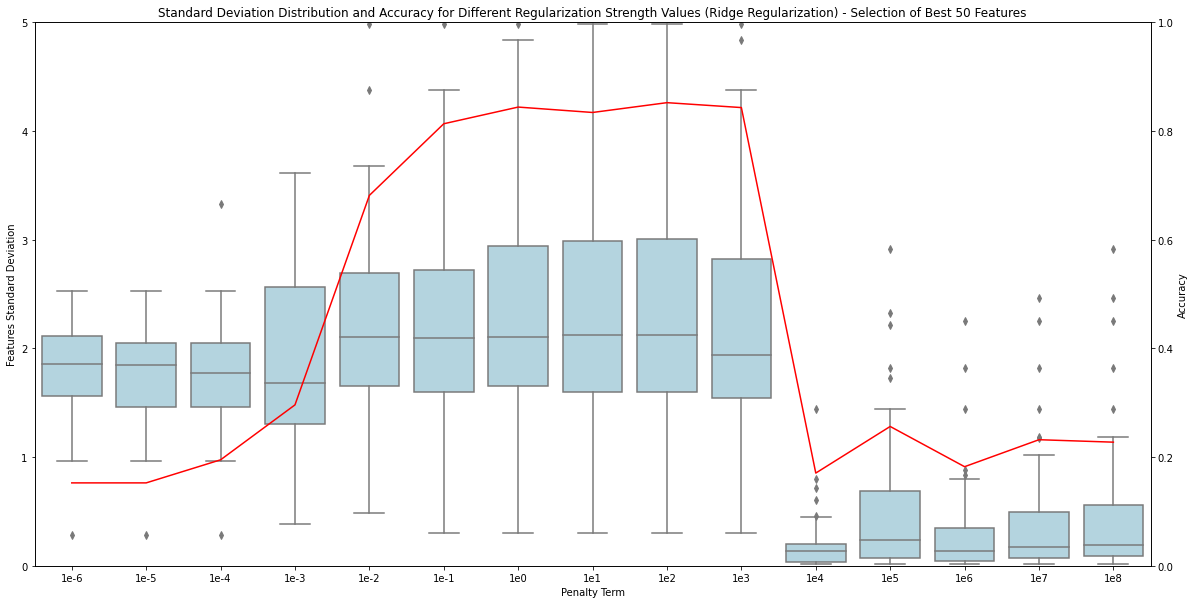

In [248]:
# Create figure and axes
fig, ax1 = plt.subplots(figsize=(20, 10))

# Add a boxplot to the left axis
sns.boxplot(data=reg_std_df.query("reg_type=='l2'"), x="log_reg", y="fts_std", color="lightblue", ax=ax1)
ax1.set_ylim(0, 5)

# Add a line plot to the right axis
ax2 = ax1.twinx()
sns.lineplot(data=std_df.query("reg_type=='l2'"), x="log_reg", y="accuracy", color="red", ax=ax2)
ax2.set_ylim(0, 1)

# Customize plot labels and legends
ax1.set_xlabel('Penalty Term')
ax1.set_ylabel('Features Standard Deviation')
ax2.set_ylabel('Accuracy')
ax2.tick_params(axis='y')
plt.title(f"Standard Deviation Distribution and Accuracy for Different Regularization Strength Values (Ridge Regularization) - Selection of Best 50 Features")

# Show plot
plt.show()


In [ ]:
(50-len())/50

In [242]:
for i in range(14):
    p = (50-len(set(l2_features_dict[i]) - set(l2_features_dict[i+1])))/50
    print(p)

0.78
0.78
0.04
0.3
0.7
0.9
0.92
0.94
0.6
0.0
0.16
0.66
0.72
0.8


In [225]:
(50-len(set(l2_features_dict[14]) - set(l2_features_dict[13])))/50

0.8

In [226]:
(50-len(set(l2_features_dict[13]) - set(l2_features_dict[12])))/50

0.72

In [ ]:
(50-len(set(l2_features_dict[13]) - set(l2_features_dict[12])))/50